# 4 AutoML : Regression


In this example we use the scikit-learn's [diabetes dataset](http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) to showcase how you can use AutoML for a simple regression problem.

Make sure you have executed the [00.configuration](00.configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Test the best fitted model.


In [1]:
#!pip install azureml-sdk

In [2]:
import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 0.1.74


## 1. Création expérimentation

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [3]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [4]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-local-regression'
project_folder = './sample_projects/automl-local-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Found the config file in: /home/nbuser/library/aml_config/config.json


,
Experiment Name,automl-local-regression
Location,westeurope
Project Directory,./sample_projects/automl-local-regression
Resource Group,mlserviceresourcegroup
SDK version,0.1.74
Subscription ID,70b8f39e-8863-49f7-b6ba-34a80799550c
Workspace Name,MLServiceWorkspace


### Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [5]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

## 2. Chargement des données

This uses scikit-learn's [load_diabetes](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) method.

In [6]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 3. Configuration AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**max_time_sec**|Time limit in seconds for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

In [7]:
automl_config = AutoMLConfig(task = 'regression',
                             max_time_sec = 600,
                             iterations = 30,
                             primary_metric = 'spearman_correlation',
                             n_cross_validations = 5,
                             debug_log = 'automl.log',
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## 4. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

> `spearman_correlation` is the metric

In [8]:
local_run = experiment.submit(automl_config, show_output = True)

Parent Run ID: AutoML_056e9e5f-f784-419b-9d1e-9a24e96b2211
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler ExtraTreesRegressor      0:00:09.572324           0.698     0.698
         1      StandardScalerWrapper KNeighborsRegres0:00:08.037363           0.701     0.701
         2      MaxAbsScaler LightGBMRegressor        0:00:09.521561           0.684     0.701
         3      StandardScalerWrapper GradientBoosting0:00:10.086444           0.701     0.701
         4      

In [9]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-local-regression,AutoML_056e9e5f-f784-419b-9d1e-9a24e96b2211,automl,Completed,Link to Azure Portal,Link to Documentation


## 5. Exploration des résultats

### 5.1 Widget Notebook

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [10]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show() 

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

_UserRun(widget_settings={'childWidgetDisplay': 'popup', 'display': 'popup'})


### 5.2 Retrieve All
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [11]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
explained_variance,0.495558,0.460291,0.371022,0.509891,0.476664,0.491541,0.490480,0.458824,0.406171,0.453131,...,0.481644,0.081434,0.371991,0.098238,0.188529,0.542796,0.416567,0.511651,0.391109,0.448216
mean_absolute_error,47.160483,48.623435,53.634967,44.638841,46.282905,46.316555,44.982650,49.167708,51.655219,47.135098,...,47.474166,60.617802,53.531859,58.995252,56.505756,43.627292,50.846272,44.350655,49.314458,47.229135
median_absolute_error,44.183299,45.722450,49.956319,40.872725,42.001903,40.924479,40.293991,44.480263,49.540164,41.254545,...,44.088505,50.675000,51.041895,48.400000,47.070000,37.499536,47.905511,39.703746,42.165355,41.214286
normalized_mean_absolute_error,0.146917,0.151475,0.167087,0.139062,0.144184,0.144288,0.140133,0.153170,0.160920,0.146838,...,0.147895,0.188841,0.166766,0.183786,0.176030,0.135911,0.158400,0.138164,0.153628,0.147131
normalized_median_absolute_error,0.137643,0.142438,0.155627,0.127329,0.130847,0.127491,0.125526,0.138568,0.154331,0.128519,...,0.137347,0.157866,0.159009,0.150779,0.146636,0.116821,0.149238,0.123688,0.131356,0.128393
normalized_root_mean_squared_error,0.174512,0.180329,0.194382,0.172797,0.178581,0.174449,0.174868,0.181117,0.188517,0.181566,...,0.176279,0.234870,0.194839,0.232900,0.220831,0.166052,0.187160,0.171926,0.190932,0.181996
normalized_root_mean_squared_log_error,0.169105,0.169446,0.185815,0.166342,0.170832,0.165206,0.166680,0.177280,0.180548,0.170006,...,0.166710,0.217625,0.181339,0.217784,0.207419,0.161927,0.175500,0.163370,0.180893,0.170878
r2_score,0.474075,0.440167,0.351186,0.486158,0.450926,0.474400,0.472716,0.434574,0.390026,0.432217,...,0.465454,0.047834,0.348518,0.069166,0.158192,0.523964,0.398230,0.488944,0.371265,0.429714
root_mean_squared_error,56.018487,57.885652,62.396556,55.467991,57.324374,55.998023,56.132474,58.138573,60.513928,58.282579,...,56.585444,75.393189,62.543297,74.760959,70.886766,53.302782,60.078417,55.188153,61.289104,58.420757
root_mean_squared_log_error,0.438189,0.439072,0.481489,0.431029,0.442665,0.428087,0.431905,0.459374,0.467842,0.440525,...,0.431984,0.563916,0.469891,0.564327,0.537469,0.419589,0.454760,0.423329,0.468735,0.442785


### 5.3 Obtention du meilleur modèle

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [12]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-regression,
Id: AutoML_056e9e5f-f784-419b-9d1e-9a24e96b2211_10,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7ff7cabef048>), ('SGDRegressor', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.3877551020408163,
       learning_rate='constant', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=100, penalty='l1', power_t=0.4444444444444444,
       random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False))])


### Changement de métrique
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [13]:
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-regression,
Id: AutoML_056e9e5f-f784-419b-9d1e-9a24e96b2211_25,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SGDRegressor', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0001,
       fit_intercept=True, l1_ratio=0.8775510204081632,
       learning_rate='constant', loss='squared_epsilon_insensitive',
       max_iter=None, n_iter=2000, penalty='l2', power_t=0,
       random_state=None, shuffle=True, tol=0.1, verbose=0,
       warm_start=False))])


### Choix d'une itération spécifique
Show the run and the model from the third iteration:

In [14]:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-local-regression,
Id: AutoML_056e9e5f-f784-419b-9d1e-9a24e96b2211_3,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7ff7cc27ee80>), ('GradientBoostingRegressor', GradientBoostingRegressor(alpha=0.5, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
     ...       random_state=None, subsample=0.44999999999999996, verbose=0,
             warm_start=False))])


## 6. Validation

Predict on training and test set, and calculate residual values.

In [15]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

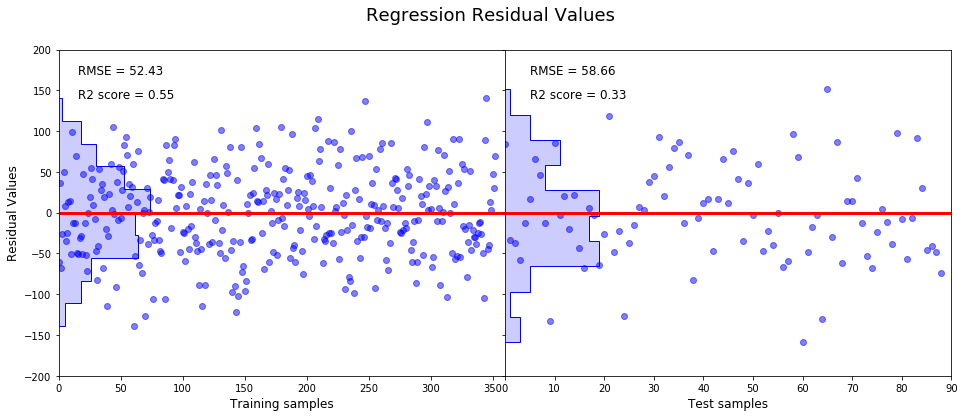

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step');
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10);

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()

> Fin